# Measuring the area of the crests

In [1]:
%matplotlib inline

import re
import glob
import os.path
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy
import scipy.linalg
import scipy.integrate
#import scipy.stats
#import scipy.spatial.distance as sad
#import matplotlib.image as mpimg
#import matplotlib.patches as mpatches

from IPython.display import display

import area

## Reading the contours

In [2]:
with open('bone-area.TPS', encoding='latin1') as infile:
    bones = area.tps_to_dataframe(infile)
with open('keratin-area.TPS', encoding='latin1') as infile:
    keratines = area.tps_to_dataframe(infile)
area.add_groups(bones)
area.add_groups(keratines)

id                               2
image    pictures/bony-crest/5.JPG
Name: 2, dtype: object


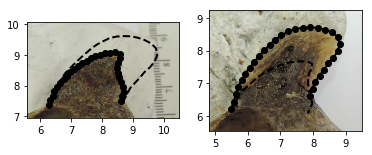

In [20]:
record_bone = bones.loc[2]
record_keratine = keratines.loc[2]
print(record_bone[['id', 'image']])
lm_bone, cp_bone = area.record_to_arrays(record_bone)
lm_keratine, cp_keratine = area.record_to_arrays(record_keratine)
fig, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
area.draw_one(ax1, record_bone['image'],
              cp_bone * record_bone['scale'],
              cp_keratine * record_keratine['scale'],
              record_bone['scale'], marker_main='o', only_crest=True)
area.draw_one(ax2, record_keratine['image'],
              cp_keratine * record_keratine['scale'],
              cp_bone * record_bone['scale'],
              record_keratine['scale'], marker_main='o', only_crest=True)

#ax1.set_ylim(4, 10)

## Calculate crest area

We computed the crest areas using the composite trapezoidal rule as implemented in the scipy library. For each crest, we first aligned the base of the crest on the abscissa, and then calculated the area under the curve.

Text(0,0.5,'Y (cm)')

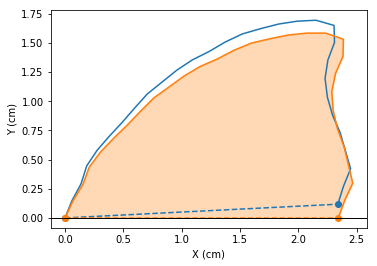

In [4]:
record = bones.loc[2]
_, before = area.record_to_arrays(record)
before *= record['scale']
after = area.align_base(before)

fig, ax1 = plt.subplots(1)

ax1.set_aspect('equal')
lines_before = ax1.plot(before[:, 0], before[:, 1])
lines_after = ax1.plot(after[:, 0], after[:, 1])

ax1.plot(before[[0, -1], 0], before[[0, -1], 1], 'o--',
         color=lines_before[0].get_color())
ax1.plot(after[[0, -1], 0], after[[0, -1], 1], 'o--',
         color=lines_after[0].get_color())
ax1.axhline(y=0, color='k', lw=1)

ax1.fill_between(after[:, 0], after[:, 1], color=lines_after[0].get_color(), alpha=0.3)

limits_x = (min(before[:, 0].min(), after[:, 0].min()),
            max(before[:, 0].max(), after[:, 0].max()))
limits_y = (min(before[:, 1].min(), after[:, 1].min()),
            max(before[:, 1].max(), after[:, 1].max()))
ax1.set_xlabel('X (cm)')
ax1.set_ylabel('Y (cm)')

In [5]:
area.get_areas(bones)
area.get_areas(keratines)

## Estimate error

Uncertainties in areas accumulate at each steps of the analysis. Uncertainties are due to small variations of frame when taking the photographs, to the manual scale assignation, to the drawing of the contour, and finally to the limited sampling to calculate areas and perimeters. To estimate the uncertainty associated to the areas we computed, we repeated the whole procedure 6 times on 5 different skulls.

In [6]:
def error_image_index(path):
    path = pathlib.PureWindowsPath(path)
    return path.parts[-2]


def fix_error_image_index(df):
    for ix in df.index:
        df.loc[ix, 'photo_index'] = error_image_index(df.loc[ix, 'image'])


error_df = []

for error_file_path in glob.glob('error_estimate/error*.TPS'):
    with open(error_file_path, encoding='latin1') as infile:
        df = area.tps_to_dataframe(infile)
        area.get_areas(df)
        fix_error_image_index(df)
        error_df.append(df)

error_df = pd.concat(error_df, ignore_index=True)

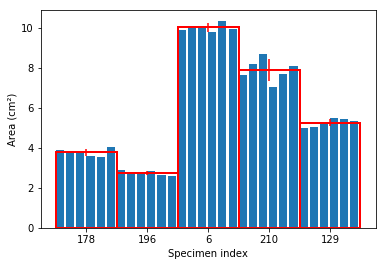

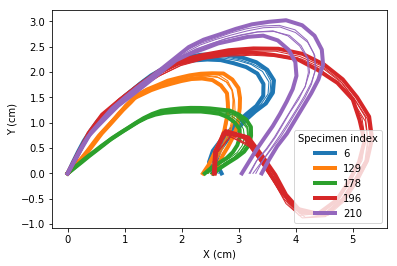

In [7]:
grouped = error_df.groupby(['photo_index'])

fig, ax = plt.subplots()

ax.bar(numpy.arange(len(error_df)), error_df.sort_values(by='photo_index')['area_trapz_scaled'], align='edge')
ax.bar(numpy.arange(len(error_df['photo_index'].unique())) * 6,
       grouped.mean()['area_trapz_scaled'],
       width=6, align='edge',
       linewidth=2, facecolor='none', edgecolor='red', ecolor='red',
       yerr=grouped.std()['area_trapz_scaled']
      )
ax.set_ylabel('Area (cm²)')
ax.set_xticks(numpy.arange(len(error_df['photo_index'].unique())) * 6 + 3)
ax.set_xticklabels(error_df['photo_index'].unique())
ax.set_xlabel('Specimen index');

fig, ax2 = plt.subplots()

for photo_index, group in sorted(grouped, key=lambda x: int(x[0])):
    group = group.sort_values(by='area_trapz_scaled')
    # Plot the smallest
    record = group.iloc[0]
    _, curve = area.record_to_arrays(record)
    aligned = area.align_base(curve) * record['scale']
    lines = ax2.plot(aligned[:, 0], aligned[:, 1], lw=4, label=photo_index)
    # Plot the largest
    record = group.iloc[-1]
    _, curve = area.record_to_arrays(record)
    aligned = area.align_base(curve) * record['scale']
    ax2.plot(aligned[:, 0], aligned[:, 1], lw=4, color=lines[0].get_color())
    # Plot all of them
    for index in group.index:
        record = group.loc[index]
        _, curve = area.record_to_arrays(record)
        aligned = area.align_base(curve) * record['scale']
        ax2.plot(aligned[:, 0], aligned[:, 1], lw=1, color=lines[0].get_color())

ax2.set_xlabel('X (cm)')
ax2.set_ylabel('Y (cm)')
ax2.legend(loc='best', title='Specimen index')

1.0	1.0	1.0024230232386713	1.0
1.0426366086743444	1.087091097747938	1.0067613999795506	1.0917959086155589
1.0747365841705463	1.1550587253545737	1.0	1.1522667562270872
1.1036510659152168	1.2180456752957942	1.0184544488276044	1.2375254838743497
1.0747365841705463	1.1550587253545737	1.0113708509591035	1.165369009777275
1.0426366086743444	1.087091097747938	1.0053501494475081	1.0902654590403698


Text(0.5,1,'Specimen 210, scaled')

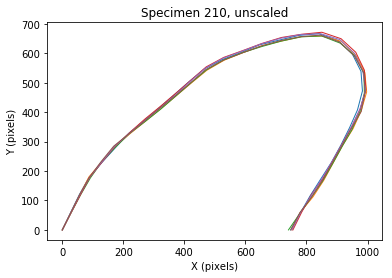

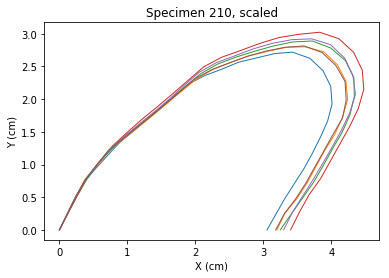

In [15]:
plt.figure()
for record in group.iterrows():
    _, curve = area.record_to_arrays(record[1])
    aligned = area.align_base(curve)
    lines = plt.plot(aligned[:, 0], aligned[:, 1], lw=1, label=photo_index)
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.title('Specimen 210, unscaled')

plt.figure()
for record in group.iterrows():
    _, curve = area.record_to_arrays(record[1])
    scale = record[1]['scale']
    aligned = area.align_base(curve)
    lines = plt.plot(aligned[:, 0] * scale, aligned[:, 1] * scale, lw=1, label=photo_index)
    print((scale / 0.004081), (scale / 0.004081) ** 2, record[1]['area_trapz'] / group['area_trapz'].min(), record[1]['area_trapz_scaled'] / group['area_trapz_scaled'].min(), sep='\t')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('Specimen 210, scaled')

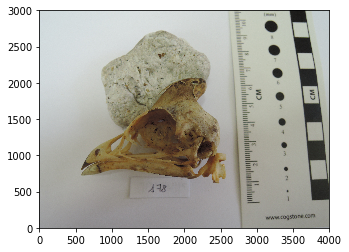

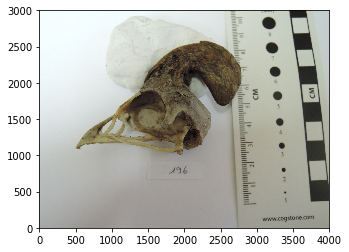

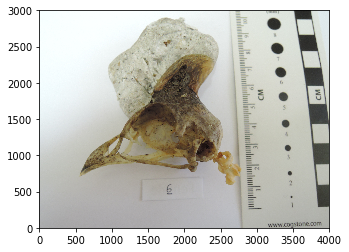

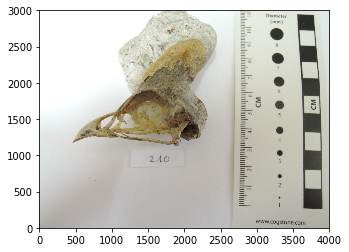

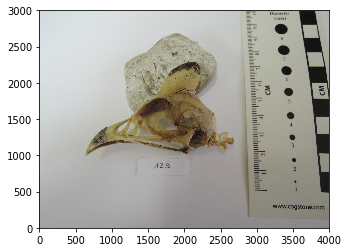

In [9]:
for photo_index in error_df['photo_index'].unique():

    img_path = 'pictures/keratine-crest/{}.JPG'.format(photo_index)
    img = plt.imread(img_path)

    group = error_df.query("photo_index == '210'")
    #scale = group
    extent = [0, img.shape[1],
              0, img.shape[0]]
    plt.figure()
    plt.imshow(img[::-1, :], extent=extent, origin='lower')

photo_index
129    0.178120
178    0.115586
196    0.204944
210    0.569889
6      0.188147
Name: area_trapz_scaled, dtype: float64
photo_index
129    0.480683
178    0.326058
196    0.586020
210    1.667674
6      0.454684
Name: area_trapz_scaled, dtype: float64


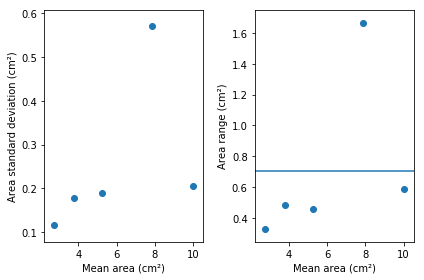

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.scatter(grouped.mean()['area_trapz_scaled'],
            grouped.std()['area_trapz_scaled'])
ax1.set_xlabel('Mean area (cm²)')
ax1.set_ylabel('Area standard deviation (cm²)')

area_range = (grouped.max()['area_trapz_scaled']
              - grouped.min()['area_trapz_scaled'])
ax2.scatter(grouped.mean()['area_trapz_scaled'],
            area_range)
ax2.set_xlabel('Mean area (cm²)')
ax2.set_ylabel('Area range (cm²)')
ax2.axhline(y=area_range.mean())

plt.tight_layout()

print(grouped.std()['area_trapz_scaled'])
print(area_range)

The error on the crest area does not appear to depend on the area. Instead, most of our tests show a standard deviation of about 0.2 cm² and a range of about 0.5 cm². However, one test shows a standard deviation of 0.57 cm², and a range of 1.67 cm². We use the average area range of 0.7 cm² as error estimate. This error is above the standard deviation for all the tests; it is also greater that most area range. We are confident that this error estimate is conservative for most case, and only underestimate the error on a few of the least accurate areas.

The main source of error appears to be the assignation of the scale between pixels and centimeters.

In [11]:
area_error = (grouped.max()['area_trapz_scaled']
              - grouped.min()['area_trapz_scaled']).mean()
print(area_error, 'cm²')

0.7030236678968009 cm²


## Reporting areas

In [24]:
bones[['photo_index', 'area_trapz_scaled']]

,photo_index,area_trapz_scaled
id,,
2,5,2.732394
3,6,2.958230
4,8,2.805125
5,12,3.454449
6,13,2.347301
7,16,3.903430
8,19,3.656577
9,20,4.340935
10,26,4.955262


In [29]:
keratines[['photo_index', 'area_trapz_scaled']]

,photo_index,area_trapz_scaled
id,,
1,5,4.912405
2,6,4.873386
4,8,3.916300
7,12,4.398553
8,13,4.053008
11,16,6.521175
13,19,5.677711
14,20,5.164738
17,26,6.407782
